In [1]:
import diffusion, torch
from diffusion import DDPMManager as Manager

device = torch.device("cuda:1")
ckpt_path = "experiments/ddpm_cifar10_100.exp/checkpoints/last.model"
manager = Manager.from_checkpoint(ckpt_path, map_location=device)

'''
model = torch.load("/home/kisonho/Documents/Models/bbdm_new/bbdm_new_1.pth", map_location=device)
manager = BBDMNewManager(model, 1000)
'''

'\nmodel = torch.load("/home/kisonho/Documents/Models/bbdm_new/bbdm_new_1.pth", map_location=device)\nmanager = BBDMNewManager(model, 1000)\n'

In [2]:
import os

import data

data_dir = os.path.normpath("/home/kisonho/Public/share/Data/Cifar10/")
_, testing_dataset, in_channels, _ = data.Datasets("cifar10").load(data_dir, 1, device=device)
x = testing_dataset[1]

Files already downloaded and verified
Files already downloaded and verified


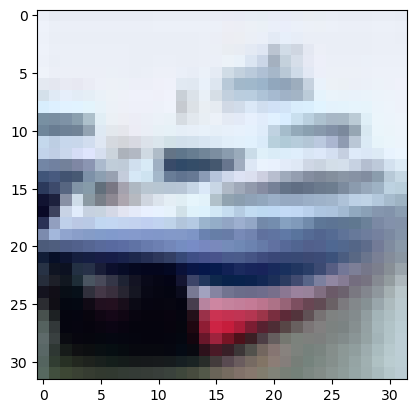

In [4]:
from matplotlib import pyplot as plt
img = x / (x.max() - x.min())
img += 0.5
img = img.clip(0,1)
plt.imshow(img.permute((1,2,0)).detach().cpu().numpy())

In [5]:
import torch
from diffusion.data import DiffusionData

assert isinstance(manager, Manager)

x = x.unsqueeze(0).to(device)
# x_t = x
x_t = torch.randn_like(x, dtype=torch.float, device=device)

# initialize
images: list[torch.Tensor] = []
noises: list[torch.Tensor] = []

# sampling loop
with torch.no_grad():
    for i in reversed(range(1, manager.time_steps+1)):
        # step1 create t
        t = torch.full((1,), i, dtype=torch.long, device=x_t.device)

        # sampling
        x_t_wrapped = DiffusionData(x_t, t, condition=x)
        x_t, noise = manager.sampling_step(x_t_wrapped, i, return_noise=True)

        if i % 100 == 0:
            print(i)
            images.append(x_t.detach().cpu())
            noises.append(noise.detach().cpu())

    # add x_0
    x_0 = x_t
    images.append(x_0.detach().cpu())

1000
900
800
700
600
500
400
300
200
100


In [6]:
x_t.shape

torch.Size([1, 3, 32, 32])

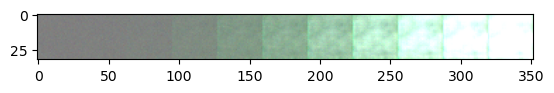

In [8]:
backward_images = torch.cat(images, dim=-1)
denormalized_backward_imgs = backward_images / (backward_images.max() - backward_images.min())
denormalized_backward_imgs += 0.5
denormalized_backward_imgs = denormalized_backward_imgs.clip(0,1)
plt.imshow(denormalized_backward_imgs.squeeze(0).permute((1,2,0)).cpu().detach().numpy())

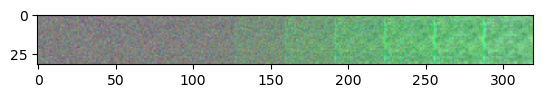

In [10]:
backward_noises = torch.cat(noises, dim=-1)
denormalized_backward_noises = backward_noises / (backward_noises.max() - backward_noises.min())
denormalized_backward_noises += 0.5
denormalized_backward_noises = denormalized_backward_noises.clip(0,1)
plt.imshow(denormalized_backward_noises.squeeze(0).permute((1,2,0)).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


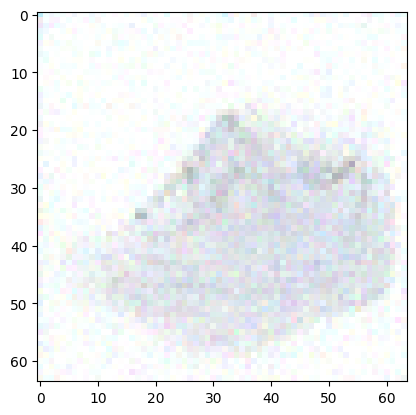

In [9]:
plt.imshow(images[-1].squeeze(0).permute((1,2,0)).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


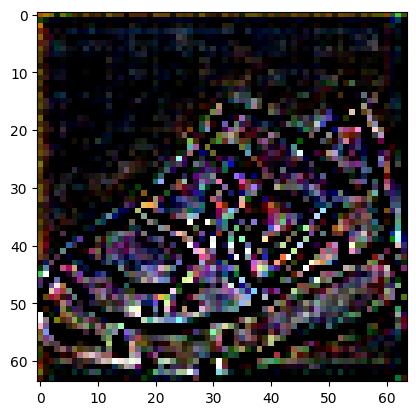

In [10]:
plt.imshow(noises[0].squeeze(0).permute((1,2,0)).cpu().detach().numpy())